--- Aave V3 Systemic Risk: Price Sweep Characterization ---
 Price_Drop_Pct  Systemic_HF Status
              0       3.2405 SECURE
              5       3.1977 SECURE
             10       3.1548 SECURE
             15       3.1119 SECURE
             20       3.0691 SECURE
             25       3.0262 SECURE
             30       2.9834 SECURE
             35       2.9405 SECURE
             40       2.8976 SECURE
             45       2.8548 SECURE
             50       2.8119 SECURE
             55       2.7690 SECURE
             60       2.7262 SECURE
             65       2.6833 SECURE
             70       2.6404 SECURE
             75       2.5976 SECURE
             80       2.5547 SECURE
             85       2.5118 SECURE
             90       2.4690 SECURE


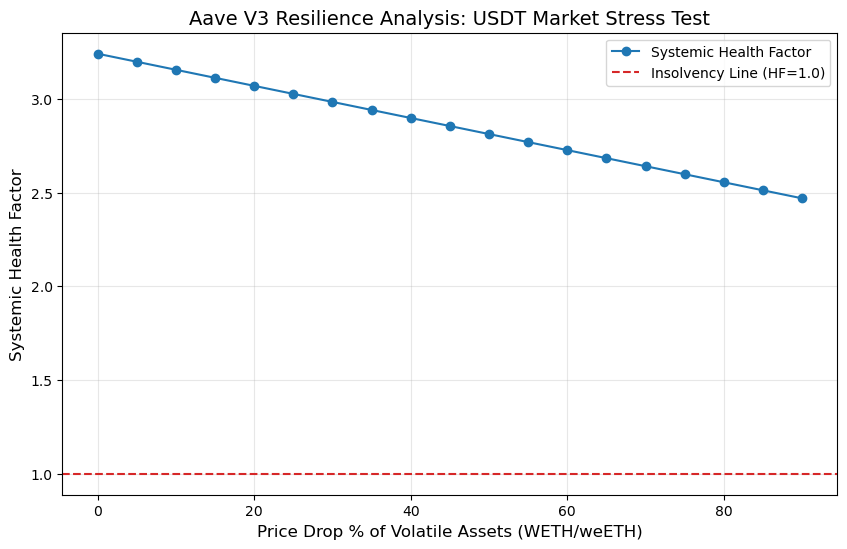

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Protocol Parameters & Data Initialization ---
# Total USDT debt from Pareto Concentration Audit
TOTAL_DEBT = 867010419  

# Aggregated collateral volumes and their specific Liquidation Thresholds (LT)
# Note: USDC is treated as a stable buffer, while weETH and WETH are volatile
collateral_data = {
    'USDC':  {'volume': 2755076761, 'lt': 0.75,  'is_stable': True},
    'weETH': {'volume': 779958693,  'lt': 0.80,  'is_stable': False},
    'WETH':  {'volume': 144608037,  'lt': 0.825, 'is_stable': False}
}

def run_systemic_price_sweep():
    sweep_results = []
    
    # --- 2. Stress Testing Loop: Simulating Price Crashes ---
    # We sweep from 0% (current price) to 90% drop (extreme crash scenario)
    for drop_percent in range(0, 91, 5):
        multiplier = 1 - (drop_percent / 100)
        
        total_collateral_value = 0
        total_borrowing_capacity = 0 # Weighted by LT
        
        for token, info in collateral_data.items():
            # Apply price drop only to volatile assets; USDC remains pegged at $1.00
            current_price = 1.0 if info['is_stable'] else 1.0 * multiplier
            
            asset_market_value = info['volume'] * current_price
            total_collateral_value += asset_market_value
            
            # Systemic Capacity = Market Value * Liquidation Threshold
            total_borrowing_capacity += asset_market_value * info['lt']
            
        # --- 3. Calculating the Systemic Health Factor (SHF) ---
        # SHF = Total Risk-Adjusted Collateral / Total Debt
        # If SHF <= 1.0, the protocol enters a mass-liquidation state
        systemic_hf = total_borrowing_capacity / TOTAL_DEBT
        
        sweep_results.append({
            'Price_Drop_Pct': drop_percent,
            'Systemic_HF': round(systemic_hf, 4),
            'Total_Value_USD': round(total_collateral_value, 2),
            'Status': 'SECURE' if systemic_hf > 1.0 else 'AT_RISK'
        })
    
    return pd.DataFrame(sweep_results)

# --- 4. Execution and Reporting ---
df_report = run_systemic_price_sweep()

# Output the result table for the audit report
print("--- Aave V3 Systemic Risk: Price Sweep Characterization ---")
print(df_report[['Price_Drop_Pct', 'Systemic_HF', 'Status']].to_string(index=False))

# --- 5. Visualization: The Liquidation Cliff ---
plt.figure(figsize=(10, 6))
plt.plot(df_report['Price_Drop_Pct'], df_report['Systemic_HF'], 
         marker='o', linestyle='-', color='#1f77b4', label='Systemic Health Factor')

# Red line indicates the systemic solvency threshold
plt.axhline(y=1.0, color='#d62728', linestyle='--', label='Insolvency Line (HF=1.0)')

plt.title('Aave V3 Resilience Analysis: USDT Market Stress Test', fontsize=14)
plt.xlabel('Price Drop % of Volatile Assets (WETH/weETH)', fontsize=12)
plt.ylabel('Systemic Health Factor', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()